# 1. LEP Training

## 1.1 Dataset Preparation

In [1]:
from lep.train import Config, StructureAnalyzer, NNmodel, EnergyDataset, EnergyTrainer
from ase.db import connect
import torch

In [2]:
db = connect("example.db")

In [3]:
analyzer = StructureAnalyzer(
    element_list=['Ti', 'Al', 'Nb', 'Mo', 'Zr'],
    lattice_constant=3.31,
    n_layers=6, #neighbor_layer_cutoff
    lattice_type='BCC',
    neighbor_distances=None#If your lattice_type is not in ['BCC','FCC','HCP'], neighbor_distances require manual adjustments.
)

In [4]:
sc = []
for row in db.select(nowarning='Yes'):
    atoms = row.toatoms()
    features = analyzer.create_atomic_environment_df(atoms, PBC_layers=2).values # Parameter 'PBC_layers' should be larger when structures in db are small.
    sc.append((torch.tensor(features, dtype=torch.float32), row.mixing_energy))
len(sc)

664

## 1.2 Model Training

Epoch  10/50 | Train Loss: 1.2903e-03 | Val Loss: 1.3237e-03
Epoch  20/50 | Train Loss: 5.0256e-04 | Val Loss: 5.3509e-04
Epoch  30/50 | Train Loss: 1.5160e-04 | Val Loss: 2.3889e-04
Epoch  40/50 | Train Loss: 1.0998e-04 | Val Loss: 1.8572e-04
Epoch  50/50 | Train Loss: 9.4478e-05 | Val Loss: 1.7024e-04


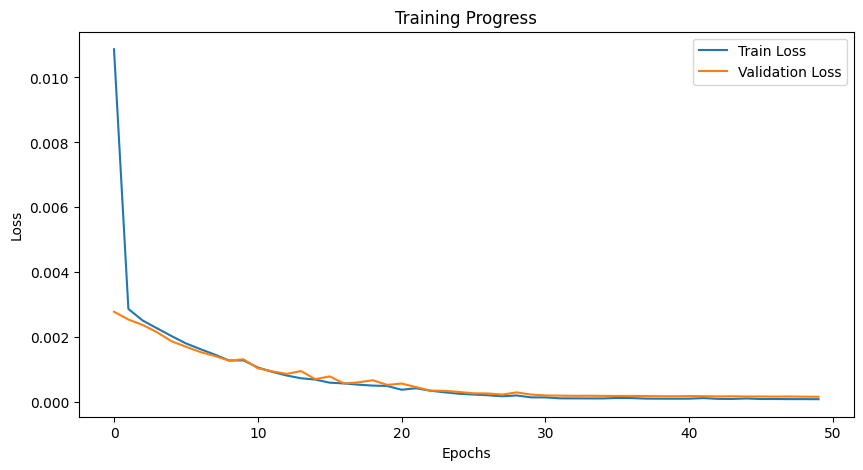

CPU times: user 5.26 s, sys: 877 ms, total: 6.14 s
Wall time: 6.01 s


In [5]:
%%time
# 1.2 Model Training
model = NNmodel(
    input_size=analyzer.input_dim,
    hidden_sizes=[500, 500, 10],
    activation='relu',
    dropout_rate=0,
    per_atom_output=False
)

trainer = EnergyTrainer(
    model=model,
    train_ratio=0.8,
    batch_size=16,
    lr=0.0005,
    loss_fn='mse',
    optimizer_name='adam',
    scheduler_name='step_lr',
    device='cuda'
)

dataset = EnergyDataset(sc)
trainer.prepare_data(dataset)

# training
train_losses, val_losses = trainer.train(
    epochs=50,
    verbose=Config.VERBOSE_TRAIN
)

trainer.plot_loss(train_losses, val_losses)

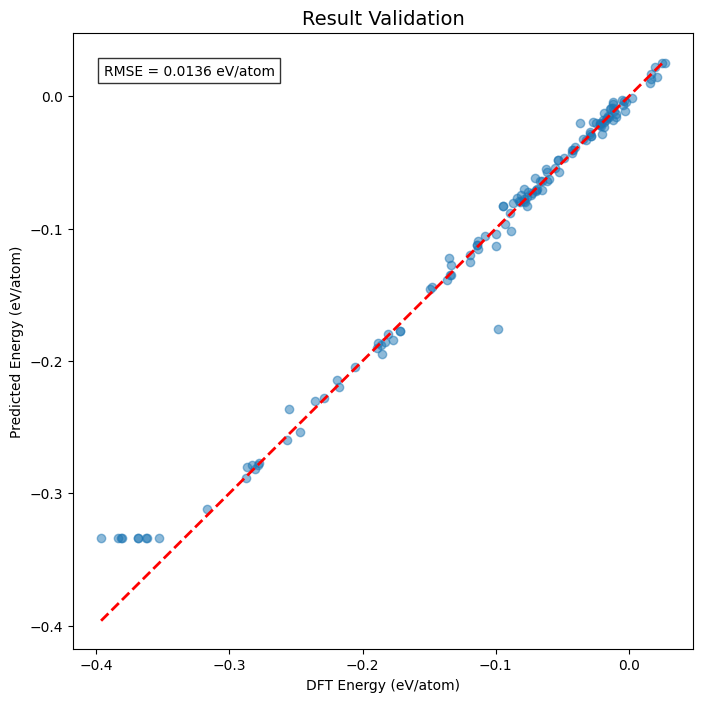

In [6]:
trainer.evaluate_val()

In [7]:
model_save_path = "lep.pt"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to lep.pt


# 2. LEP-MC

## 2.1 LEP Model Loading

In [8]:
import torch
from lep.train import Config, StructureAnalyzer, NNmodel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
analyzer = StructureAnalyzer(
    element_list=['Ti', 'Al', 'Nb', 'Mo', 'Zr'],
    lattice_constant=3.31,
    n_layers=6 #neighbor_layer
)

model = NNmodel(
    input_size=analyzer.input_dim,
    hidden_sizes=[500, 500, 10],
    activation='relu',
    dropout_rate=0
)

In [10]:
model_save_path = "lep.pt"
model.load_state_dict(torch.load(model_save_path))

model = model.to(device)
model.eval()

print(f"Model loaded from {model_save_path} and moved to {device}")

Model loaded from lep.pt and moved to cuda


## 2.2 Initial Structure Preparation

In [11]:
import numpy as np
from ase import Atoms
from ase.spacegroup import crystal

lattice_const = 3.31

initial_structure = crystal(
    symbols=['Ti'], 
    basis=[[0, 0, 0]], 
    spacegroup=229,  # Im-3m
    cellpar=[lattice_const, lattice_const, lattice_const, 90, 90, 90],
    size=(10, 10, 10)  # 10×10×10 supercell
)

print("Total number of atoms:", len(initial_structure))

elements = np.array(['Ti', 'Al', 'Nb', 'Mo', 'Zr'])
atom_types = np.repeat(elements, len(initial_structure) // len(elements)) 
np.random.shuffle(atom_types)  
initial_structure.set_chemical_symbols(atom_types)

for element in elements:
    count = sum(initial_structure.symbols == element)
    print(f"{element}: {count} atoms")

Total number of atoms: 2000
Ti: 400 atoms
Al: 400 atoms
Nb: 400 atoms
Mo: 400 atoms
Zr: 400 atoms


## 2.3 MC Parameters Defination

In [12]:
from lep.mc import MonteCarloSampler
from lep.mc_sampler import CanonicalEnsembleSampler

canonical_sampler = CanonicalEnsembleSampler(
    model=model,
    analyzer=analyzer,
    element_list=['Ti', 'Al', 'Nb', 'Mo', 'Zr'],
    lattice_constant=3.31,
    max_steps=20000,
    temperature=1200,
)

## 2.4 MC Simulation Process

### 2.4.1 Canonical Ensemble at 1200K

In [13]:
results = canonical_sampler.run_monte_carlo(
    initial_structure=initial_structure,
    save_interval=100,
    trajectory_file='MC.traj',
    log_file='energy.log',
    resume=False
)

Feature initialization time: 0.620s
Monte Carlo at 1200K: 100%|██████████████| 20000/20000 [00:22<00:00, 897.47it/s]


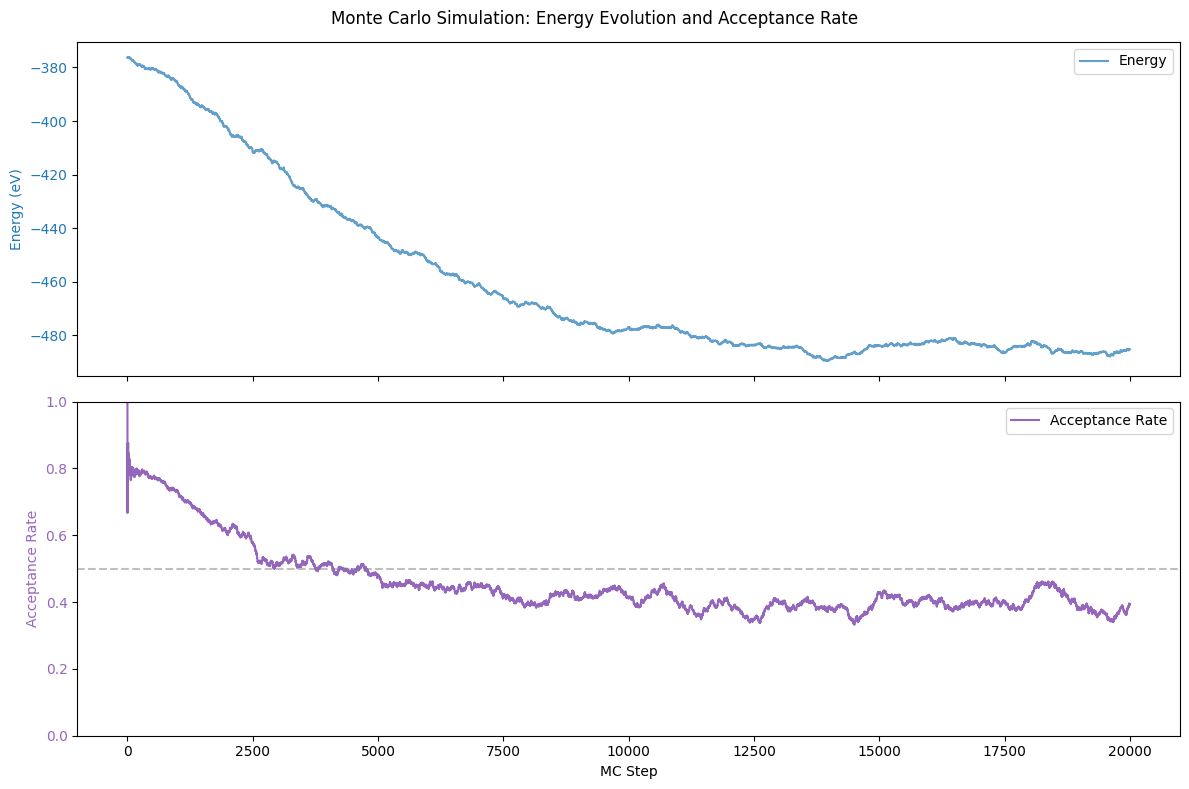

In [14]:
from lep.mc import plot_energy,read_enhanced_log_file
log_data = read_enhanced_log_file('energy.log')
plot_energy(log_data)

In [15]:
from ase.io import read, write
from ase.visualize import view
traj = read("MC.traj", index=":") 
write("trajectory.xyz", traj) 

'trajectory.xyz' can be imported into ovito or other programs for analysis.

### 2.4.2 Canonical Ensemble Annealing from 1200K to 900K

In [16]:
from lep.mc_sampler import Annealer

# Create the annealer
annealer = Annealer(
    sampler=canonical_sampler,
    initial_structure=initial_structure,
    start_temp=1200,    # Starting temperature (K)
    end_temp=900,       # Final temperature (K)
    temp_step=100,      # Temperature step (K)
    base_filename="alloy_annealing",
    output_dir="annealing_results",
    save_interval=100,
    steps_per_temp=1000
)

# Execute annealing
results = annealer.run_annealing()

# Get final structure
final_structure = annealer.get_final_structure()

2025-08-14 01:58:13,517 - lep.mc_sampler - INFO - Created output directory: annealing_results



Starting Annealing Process
  Start Temperature: 1200K
  End Temperature: 900K
  Temperature Step: 100K
  Steps per Temperature: 1000
  Total Temperatures: 4
  Starting from Temperature: 1200.0K


------------------------------------------------------------
Processing Temperature 1/4 (25.0%)
  Current Temperature: 1200.0K
  Start Temperature: 1200K
  End Temperature: 900K
  Temperature Step: 100K
  Steps per Temperature: 1000
------------------------------------------------------------

Feature initialization time: 0.702s
Monte Carlo at 1200.0K: 100%|██████████████| 1000/1000 [00:01<00:00, 848.40it/s]

2025-08-14 01:58:15,881 - lep.mc_sampler - INFO - Using cache from T=1200.0K as resume point




Completed T = 1200.0K simulation
  Saved trajectory: annealing_results/T_1200K/alloy_annealing_1200K.traj
  Saved log: annealing_results/T_1200K/alloy_annealing_1200K.txt

------------------------------------------------------------
Processing Temperature 2/4 (50.0%)
  Current Temperature: 1100.0K
  Start Temperature: 1200K
  End Temperature: 900K
  Temperature Step: 100K
  Steps per Temperature: 1000
------------------------------------------------------------

Successfully loaded cached environment data
Monte Carlo at 1100.0K: 100%|██████████████| 1000/1000 [00:01<00:00, 849.95it/s]

2025-08-14 01:58:17,114 - lep.mc_sampler - INFO - Using cache from T=1100.0K as resume point




Completed T = 1100.0K simulation
  Saved trajectory: annealing_results/T_1100K/alloy_annealing_1100K.traj
  Saved log: annealing_results/T_1100K/alloy_annealing_1100K.txt

------------------------------------------------------------
Processing Temperature 3/4 (75.0%)
  Current Temperature: 1000.0K
  Start Temperature: 1200K
  End Temperature: 900K
  Temperature Step: 100K
  Steps per Temperature: 1000
------------------------------------------------------------

Successfully loaded cached environment data
Monte Carlo at 1000.0K: 100%|██████████████| 1000/1000 [00:01<00:00, 870.57it/s]

2025-08-14 01:58:18,424 - lep.mc_sampler - INFO - Using cache from T=1000.0K as resume point




Completed T = 1000.0K simulation
  Saved trajectory: annealing_results/T_1000K/alloy_annealing_1000K.traj
  Saved log: annealing_results/T_1000K/alloy_annealing_1000K.txt

------------------------------------------------------------
Processing Temperature 4/4 (100.0%)
  Current Temperature: 900.0K
  Start Temperature: 1200K
  End Temperature: 900K
  Temperature Step: 100K
  Steps per Temperature: 1000
------------------------------------------------------------

Successfully loaded cached environment data
Monte Carlo at 900.0K: 100%|███████████████| 1000/1000 [00:01<00:00, 850.55it/s]

Completed T = 900.0K simulation
  Saved trajectory: annealing_results/T_900K/alloy_annealing_900K.traj
  Saved log: annealing_results/T_900K/alloy_annealing_900K.txt

Annealing Completed Successfully!
  Final Structure Atoms: 2000
  Total Temperatures Processed: 4

